In [104]:
%load_ext autoreload
%autoreload 2

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score, precision_score, recall_score, f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from hossam.util import *
from hossam.regression import *
from hossam.plot import *
from hossam.tensor import *
from hossam.analysis import *
from hossam.classification import *
from hossam.cluster import *

from pandas import merge, read_excel, pivot_table, melt, to_datetime, to_timedelta, DateOffset, Timestamp, Period, Series

import numpy as np
import re
import shap
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## #01. 데이터 준비

In [105]:
origin = my_read_excel("회원현황.xlsx")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10230 entries, 0 to 10229
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   카드번호        10228 non-null  float64
 1   성별          10229 non-null  object 
 2   나이          8593 non-null   float64
 3   총매출액        10229 non-null  float64
 4   얼굴등록구분      10230 non-null  object 
 5   Unnamed: 5  10230 non-null  object 
 6   유효종료일       10049 non-null  object 
 7   주민번호        10229 non-null  object 
 8   기념일         10230 non-null  object 
 9   등록여부        10229 non-null  object 
dtypes: float64(3), object(7)
memory usage: 799.3+ KB
None

상위 5개 행
+----+-------------+--------+--------+------------+----------------+--------------+--------------+----------------+----------+------------+
|    |    카드번호 | 성별   |   나이 |   총매출액 | 얼굴등록구분   | Unnamed: 5   | 유효종료일   | 주민번호       | 기념일   | 등록여부   |
|----+-------------+--------+--------+------------+----------------+--------------+--

## #02. 데이터 최종정립

### 01. 연령과 성별 추가하기

In [106]:
def calculate_age_and_gender(jumin_list):
    age_groups = []
    genders = []

    for jumin in jumin_list:
        # 유효성 검사: NaN 값 확인 및 문자열 길이 확인
        if pd.isna(jumin):
            age_groups.append(np.nan)
            genders.append(np.nan)
            continue

        # 하이픈과 별표 제거
        jumin = jumin.replace("-", "").replace("*", "")
        
        # 숫자가 아닌 문자가 포함된 경우
        if not jumin.isdigit():
            age_groups.append(np.nan)
            genders.append(np.nan)
            continue
        
        # 앞 6자리가 모두 같은지 확인
        if len(set(jumin[:6])) == 1:
            age_groups.append(np.nan)
            genders.append(np.nan)
            continue
        
        # 성별 확인
        try:
            gender_digit = int(jumin[6])
        except IndexError:
            age_groups.append(np.nan)
            genders.append(np.nan)
            continue

        if gender_digit in [1, 3]:
            genders.append(1)
        elif gender_digit in [2, 4]:
            genders.append(2)
        else:
            genders.append(np.nan)

        # 연령대 계산
        try:
            year_prefix = int(jumin[:2])
            birth_year = 1900 + year_prefix if gender_digit in [1, 2] else 2000 + year_prefix
            age = 2023 - birth_year
            
            # 나이가 100을 넘는 경우 100을 뺀다.
            if age > 100:
                age -= 100
            
            age_group = (age // 10) * 10
            age_groups.append(age_group)
        except (ValueError, IndexError):
            age_groups.append(np.nan)

    return age_groups, genders


age_groups, genders = calculate_age_and_gender(origin['주민번호'])
origin['연령대'] = age_groups
origin['성별'] = genders

origin

,카드번호,성별,나이,총매출액,얼굴등록구분,Unnamed: 5,유효종료일,주민번호,기념일,등록여부,연령대
0,NaN,NaN,NaN,NaN,등록여부,등록번호,NaN,NaN,구분,NaN,NaN
1,13120294.0,1.0,51.0,120000.0,2013-12-17,2013-12-20,2013-12-20,741204-1******,기혼,Y,40.0
2,14010043.0,1.0,78.0,0.0,2014-01-07,2014-01-08,2014-01-08,470803-1******,기혼,N,70.0
3,14010020.0,2.0,41.0,220000.0,2014-01-03,2014-01-03,2014-01-29,840218-2******,기혼,N,30.0
4,14020002.0,1.0,35.0,50000.0,2014-02-03,2014-04-04,2014-02-02,900723-1******,기혼,N,30.0
...,...,...,...,...,...,...,...,...,...,...,...
10225,16100040.0,NaN,NaN,0.0,2016-10-27,2016-11-01,NaN,666666-2******,기혼,N,NaN
10226,23030016.0,NaN,NaN,0.0,2023-03-07,2023-03-07,NaN,888888-1******,기혼,Y,NaN
10227,23050030.0,NaN,0.0,0.0,2023-05-04,2023-05-04,NaN,-******,기혼,Y,NaN
10228,23050034.0,NaN,0.0,0.0,2023-05-04,2023-05-04,NaN,-******,기혼,Y,NaN


In [107]:
origin.drop(index=0,axis=0)

,카드번호,성별,나이,총매출액,얼굴등록구분,Unnamed: 5,유효종료일,주민번호,기념일,등록여부,연령대
1,13120294.0,1.0,51.0,120000.0,2013-12-17,2013-12-20,2013-12-20,741204-1******,기혼,Y,40.0
2,14010043.0,1.0,78.0,0.0,2014-01-07,2014-01-08,2014-01-08,470803-1******,기혼,N,70.0
3,14010020.0,2.0,41.0,220000.0,2014-01-03,2014-01-03,2014-01-29,840218-2******,기혼,N,30.0
4,14020002.0,1.0,35.0,50000.0,2014-02-03,2014-04-04,2014-02-02,900723-1******,기혼,N,30.0
5,14010103.0,1.0,35.0,220000.0,2014-01-09,2014-02-05,2014-02-08,901003-1******,기혼,N,30.0
...,...,...,...,...,...,...,...,...,...,...,...
10225,16100040.0,NaN,NaN,0.0,2016-10-27,2016-11-01,NaN,666666-2******,기혼,N,NaN
10226,23030016.0,NaN,NaN,0.0,2023-03-07,2023-03-07,NaN,888888-1******,기혼,Y,NaN
10227,23050030.0,NaN,0.0,0.0,2023-05-04,2023-05-04,NaN,-******,기혼,Y,NaN
10228,23050034.0,NaN,0.0,0.0,2023-05-04,2023-05-04,NaN,-******,기혼,Y,NaN


10대, 60대,70대,80대의 데이터가 적어서 20대 이하와 60대 이상으로 합침

In [108]:
origin.loc[origin['연령대'] <= 20, '연령대'] = 1
origin.loc[origin['연령대'] == 30, '연령대'] = 2
origin.loc[origin['연령대'] == 40, '연령대'] = 3
origin.loc[origin['연령대'] == 50, '연령대'] = 4
origin.loc[origin['연령대'] >= 60, '연령대'] = 5

In [109]:
origin['연령대'].value_counts()

연령대
3.0    2581
2.0    2309
4.0    1289
1.0     550
5.0     444
Name: count, dtype: int64

In [110]:
df1 = origin.filter(items=['카드번호', '연령대', '성별'])
df1 = df1.dropna()
df1

,카드번호,연령대,성별
1,13120294.0,3.0,1.0
2,14010043.0,5.0,1.0
3,14010020.0,2.0,2.0
4,14020002.0,2.0,1.0
5,14010103.0,2.0,1.0
...,...,...,...
10176,23030075.0,1.0,1.0
10183,17080024.0,3.0,1.0
10191,14070049.0,5.0,2.0
10200,23040048.0,2.0,1.0


In [111]:
df1 = df1.rename(columns={'카드번호': '회원카드번호'})
df1

,회원카드번호,연령대,성별
1,13120294.0,3.0,1.0
2,14010043.0,5.0,1.0
3,14010020.0,2.0,2.0
4,14020002.0,2.0,1.0
5,14010103.0,2.0,1.0
...,...,...,...
10176,23030075.0,1.0,1.0
10183,17080024.0,3.0,1.0
10191,14070049.0,5.0,2.0
10200,23040048.0,2.0,1.0


In [112]:
df2 = my_read_excel("통합12.xlsx")
df2

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5058 entries, 0 to 5057
Data columns (total 51 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   회원카드번호   5058 non-null   int64  
 1   연월       5058 non-null   object 
 2   등록명      5058 non-null   object 
 3   개월수      5058 non-null   int64  
 4   종료시점     5058 non-null   object 
 5   환불여부     5058 non-null   int64  
 6   양도       5058 non-null   int64  
 7   잔여개월수    5058 non-null   int64  
 8   결제시점     5058 non-null   int64  
 9   이탈여부     5058 non-null   int64  
 10  광고       5058 non-null   int64  
 11  추세값      5058 non-null   float64
 12  환불내역     526 non-null    object 
 13  요일       1007 non-null   object 
 14  미수액      5058 non-null   int64  
 15  거래일_일    5058 non-null   int64  
 16  환불일_일    5058 non-null   int64  
 17  일일입장     5058 non-null   int64  
 18  분실       5058 non-null   int64  
 19  부가서비스사용  5058 non-null   int64  
 20  레슨여부     5058 non-null   int64  
 21  매출액      5058 

,회원카드번호,연월,등록명,개월수,종료시점,환불여부,양도,잔여개월수,결제시점,이탈여부,...,트레이너 성별,거래횟수,환불시일,문화생활비지출,소비자심리지수,CRR,월,분기,통합매출,매출액2
0,12131325,2020-09,헬스,12,2021-09,0,0,12,0,1,...,0,1,0,77,80.7,-10.456853,9,3,899000,899000
1,13120079,2020-09,헬스,12,2021-11,0,0,14,0,1,...,0,1,0,77,80.7,-10.456853,9,3,1180000,1180000
2,13120114,2020-09,헬스,12,2021-09,0,0,12,0,0,...,0,1,0,77,80.7,-10.456853,9,3,899000,899000
3,13120123,2020-09,골프,12,2021-11,0,0,14,0,0,...,0,1,0,77,80.7,-10.456853,9,3,1510000,1510000
4,13120139,2020-09,헬스,10,2021-07,0,0,10,0,0,...,0,1,0,77,80.7,-10.456853,9,3,990000,990000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5053,23010007,2023-01,헬스,0,2023-01,0,0,0,0,1,...,0,1,0,91,90.7,-10.461285,1,1,1695000,1695000
5054,23010009,2023-01,헬스,12,2024-01,0,0,12,0,0,...,0,1,0,91,90.7,-10.461285,1,1,1188000,1188000
5055,23010020,2023-01,골프,4,2023-05,0,1,4,0,1,...,0,1,0,91,90.7,-10.461285,1,1,2208000,2208000
5056,23010024,2023-01,헬스,0,2023-01,0,0,0,0,1,...,0,1,0,91,90.7,-10.461285,1,1,1695000,1695000


데이터 결합 후 쓰지않는 데이터 제거

In [113]:
df3 = df2.merge(df1,how='left')
df3 = df3.drop(columns=['결제시점','요일','거래일_일','환불일_일','개월수','종료시점','통합매출','매출액2','매출액','레슨여부','연월','등록명','트레이너','월','환불내역'])

부가서비스와 일일입장 데이터 정리

In [115]:
df3.loc[df3['부가서비스사용'] >= 2, '부가서비스사용'] = 2
df3.loc[df3['일일입장'] >= 1, '일일입장'] = 1

In [116]:
df3['연령대'] = df3['연령대'].astype(str)
df3['성별'] = df3['성별'].astype(str)

In [117]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5058 entries, 0 to 5057
Data columns (total 38 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   회원카드번호   5058 non-null   int64  
 1   환불여부     5058 non-null   int64  
 2   양도       5058 non-null   int64  
 3   잔여개월수    5058 non-null   int64  
 4   이탈여부     5058 non-null   int64  
 5   광고       5058 non-null   int64  
 6   추세값      5058 non-null   float64
 7   미수액      5058 non-null   int64  
 8   일일입장     5058 non-null   int64  
 9   분실       5058 non-null   int64  
 10  부가서비스사용  5058 non-null   int64  
 11  골프전환     5058 non-null   int64  
 12  단체회원     5058 non-null   int64  
 13  골프매출     5058 non-null   int64  
 14  라카매출     5058 non-null   int64  
 15  헬스매출     5058 non-null   int64  
 16  PT매출     5058 non-null   int64  
 17  골프레슨매출   5058 non-null   int64  
 18  일일입장매출   5058 non-null   int64  
 19  양도비매출    5058 non-null   int64  
 20  필라테스매출   5058 non-null   int64  
 21  환불사용금매출  5058 

### 02. 변수 타입 정리

In [118]:
df4 = df3.drop('회원카드번호',axis=1)
df4 = df4.astype({'환불여부':'category','양도':'category','이탈여부':'category','광고':'category','일일입장':'category','분실':'category','부가서비스사용':'category','분기':'category','성별':'category',
                    '골프전환':'category','단체회원':'category','FC 성별':'category','트레이너 성별':'category','연령대' : 'category','성별' : 'category'})

#### 라벨링 및 더미변수화

In [119]:
라벨링변수 =  df4.select_dtypes(include=['category']).columns.tolist()
라벨링변수

['환불여부',
 '양도',
 '이탈여부',
 '광고',
 '일일입장',
 '분실',
 '부가서비스사용',
 '골프전환',
 '단체회원',
 'FC 성별',
 '트레이너 성별',
 '분기',
 '연령대',
 '성별']

In [120]:
df4['연령대'].unique()

['nan', '4.0', '3.0', '5.0', '2.0', '1.0']
Categories (6, object): ['1.0', '2.0', '3.0', '4.0', '5.0', 'nan']

In [121]:
for i in range(len(라벨링변수)):
    df5=my_labelling(df4,라벨링변수[i])
my_pretty_table(df5.head())

+------------+---------+
|   환불여부 |   label |
|------------+---------|
|          0 |       0 |
|          1 |       1 |
+------------+---------+
+--------+---------+
|   양도 |   label |
|--------+---------|
|      0 |       0 |
|      1 |       1 |
+--------+---------+
+------------+---------+
|   이탈여부 |   label |
|------------+---------|
|          0 |       0 |
|          1 |       1 |
+------------+---------+
+--------+---------+
|   광고 |   label |
|--------+---------|
|      0 |       0 |
|      1 |       1 |
+--------+---------+
+------------+---------+
|   일일입장 |   label |
|------------+---------|
|          0 |       0 |
|          1 |       1 |
+------------+---------+
+--------+---------+
|   분실 |   label |
|--------+---------|
|      0 |       0 |
|      1 |       1 |
|      2 |       2 |
+--------+---------+
+------------------+---------+
|   부가서비스사용 |   label |
|------------------+---------|
|               -2 |       0 |
|               -1 |       1 |
|                0 | 

In [122]:
df5.head()

,환불여부,양도,잔여개월수,이탈여부,광고,추세값,미수액,일일입장,분실,부가서비스사용,...,FC 성별,트레이너 성별,거래횟수,환불시일,문화생활비지출,소비자심리지수,CRR,분기,연령대,성별
0,0,0,12,1,0,-0.131868,0,0,0,0,...,2,0,1,0,77,80.7,-10.456853,3,nan,2
1,0,0,14,1,0,0.005495,0,0,0,1,...,0,0,1,0,77,80.7,-10.456853,3,4.0,1
2,0,0,12,0,0,0.258242,0,0,0,0,...,0,0,1,0,77,80.7,-10.456853,3,nan,2
3,0,0,14,0,0,1.285714,0,0,1,1,...,1,0,1,0,77,80.7,-10.456853,3,nan,2
4,0,0,10,0,0,-1.081818,0,0,0,0,...,1,0,1,0,77,80.7,-10.456853,3,nan,2


In [123]:
df5['성별'] = df5['성별'].astype('category')

In [124]:
df5['추세값'] = df5['추세값'].astype(int)
df5['소비자심리지수'] = df5['소비자심리지수'].astype(int)
df5['CRR'] = df5['CRR'].astype(int)

In [125]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5058 entries, 0 to 5057
Data columns (total 37 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   환불여부     5058 non-null   category
 1   양도       5058 non-null   category
 2   잔여개월수    5058 non-null   int64   
 3   이탈여부     5058 non-null   category
 4   광고       5058 non-null   category
 5   추세값      5058 non-null   int32   
 6   미수액      5058 non-null   int64   
 7   일일입장     5058 non-null   category
 8   분실       5058 non-null   category
 9   부가서비스사용  5058 non-null   category
 10  골프전환     5058 non-null   category
 11  단체회원     5058 non-null   category
 12  골프매출     5058 non-null   int64   
 13  라카매출     5058 non-null   int64   
 14  헬스매출     5058 non-null   int64   
 15  PT매출     5058 non-null   int64   
 16  골프레슨매출   5058 non-null   int64   
 17  일일입장매출   5058 non-null   int64   
 18  양도비매출    5058 non-null   int64   
 19  필라테스매출   5058 non-null   int64   
 20  환불사용금매출  5058 non-null   int64

## #03. 데이터 확인

### 01. 요약통계

In [126]:
# 전체 데이터프레임에 대한 요약 통계량
summary_stats = df5.describe(include=['int'])
print(summary_stats)

# 범주형 데이터의 value_counts
categorical_columns = df5.select_dtypes(include=['category']).columns
for col in categorical_columns:
    print(f"\n{col} value counts:")
    print(df5[col].value_counts())

             잔여개월수          추세값           미수액          골프매출           라카매출  \
count  5058.000000  5058.000000  5.058000e+03  5.058000e+03    5058.000000   
mean      7.874456     0.093515  4.081166e+04  3.080147e+05   60719.652036   
std       6.208864     1.052391  2.249351e+05  6.949126e+05   90258.099612   
min     -24.000000    -3.000000 -5.550000e+05 -2.028000e+06 -360000.000000   
25%       3.000000     0.000000  0.000000e+00  0.000000e+00       0.000000   
50%      10.000000     0.000000  0.000000e+00  0.000000e+00   50000.000000   
75%      12.000000     0.000000  0.000000e+00  6.000000e+05  120000.000000   
max      27.000000    21.000000  3.850000e+06  2.700000e+06  480000.000000   

               헬스매출          PT매출        골프레슨매출         일일입장매출          양도비매출  \
count  5.058000e+03  5.058000e+03  5.058000e+03    5058.000000    5058.000000   
mean   4.216041e+05  2.704734e+05  7.010881e+04     653.420324    1897.983393   
std    5.906326e+05  9.497433e+05  2.555168e+05    514

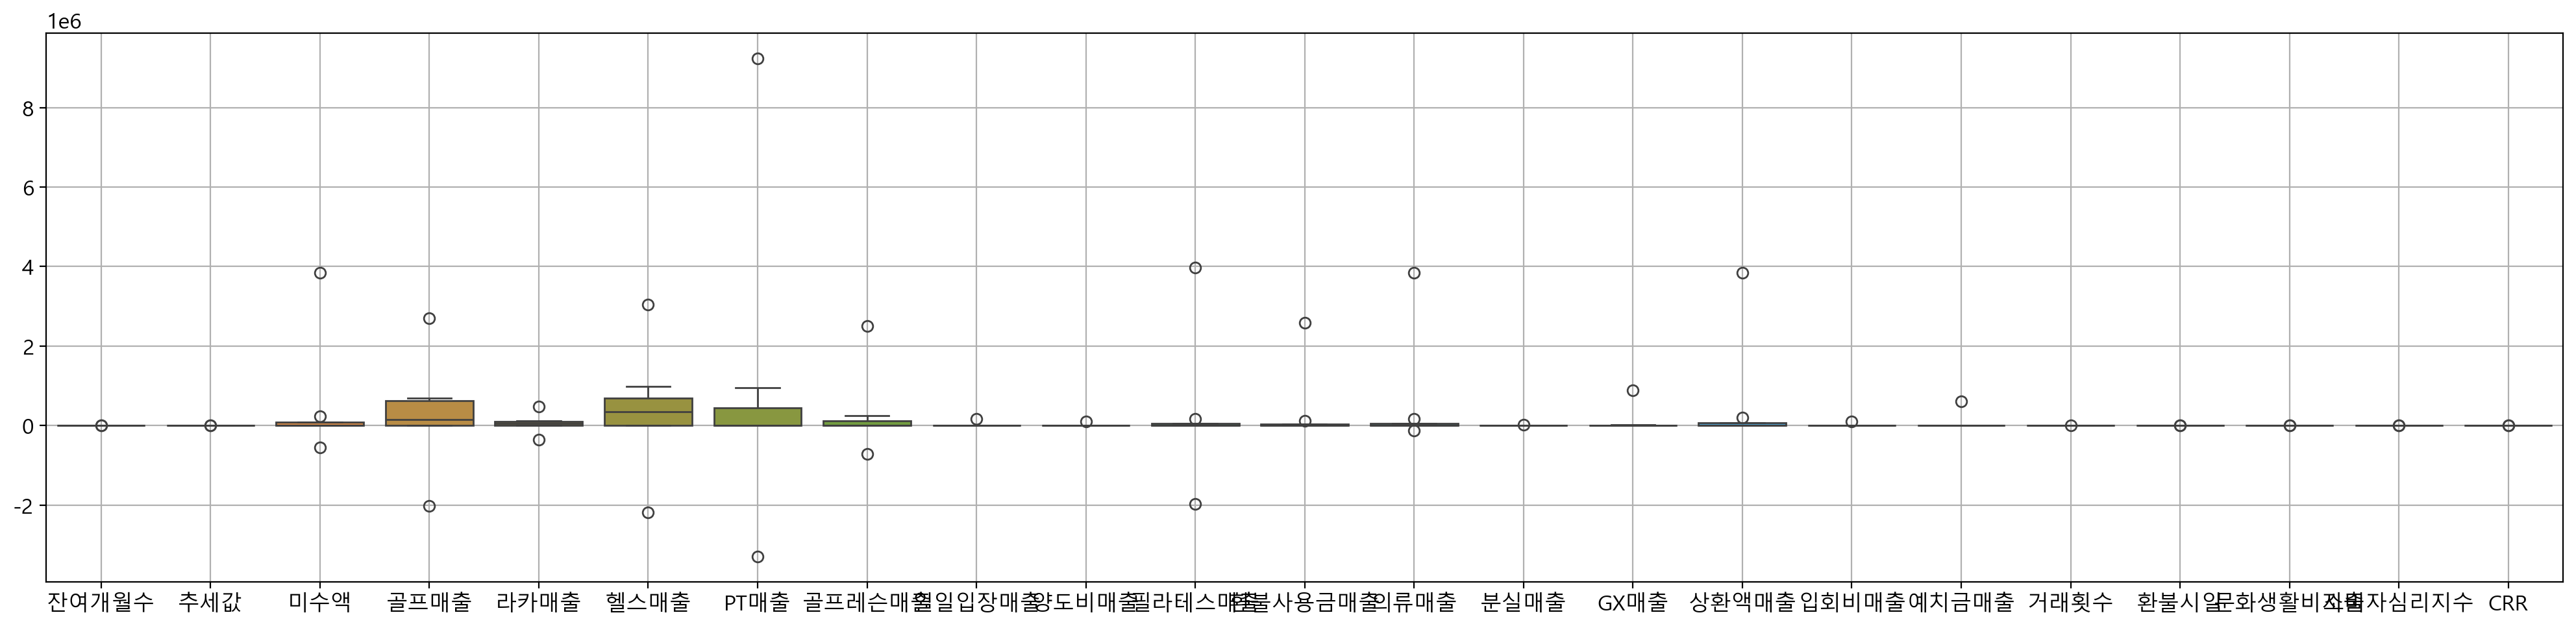

In [128]:
my_boxplot(summary_stats,figsize=(20,5),dpi=200)

> 존재하는 이상치는 실제로 발생할 수 있는 수치들

In [129]:
더미화변수 = ['이탈여부','환불여부','양도','광고','골프전환','단체회원','FC 성별','트레이너 성별','분기','연령대','성별']
df6 = pd.get_dummies(df5, columns = 더미화변수, drop_first=True)
df6

,잔여개월수,추세값,미수액,일일입장,분실,부가서비스사용,골프매출,라카매출,헬스매출,PT매출,...,분기_2,분기_3,분기_4,연령대_2.0,연령대_3.0,연령대_4.0,연령대_5.0,연령대_nan,성별_1,성별_2
0,12,0,0,0,0,0,0,0,899000,0,...,False,True,False,False,False,False,False,True,False,True
1,14,0,0,0,0,1,0,100000,1080000,0,...,False,True,False,False,False,True,False,False,True,False
2,12,0,0,0,0,0,0,0,899000,0,...,False,True,False,False,False,False,False,True,False,True
3,14,1,0,0,1,1,1320000,180000,0,0,...,False,True,False,False,False,False,False,True,False,True
4,10,-1,0,0,0,0,0,0,990000,0,...,False,True,False,False,False,False,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5053,0,0,0,0,0,1,0,45000,0,1650000,...,False,False,False,False,False,True,False,False,False,False
5054,12,0,0,0,0,0,0,0,1188000,0,...,False,False,False,False,False,True,False,False,False,False
5055,4,0,0,0,0,1,1788000,60000,0,0,...,False,False,False,False,True,False,False,False,True,False
5056,0,0,0,0,0,1,0,45000,0,1650000,...,False,False,False,False,True,False,False,False,True,False


### 02. p-value 확인

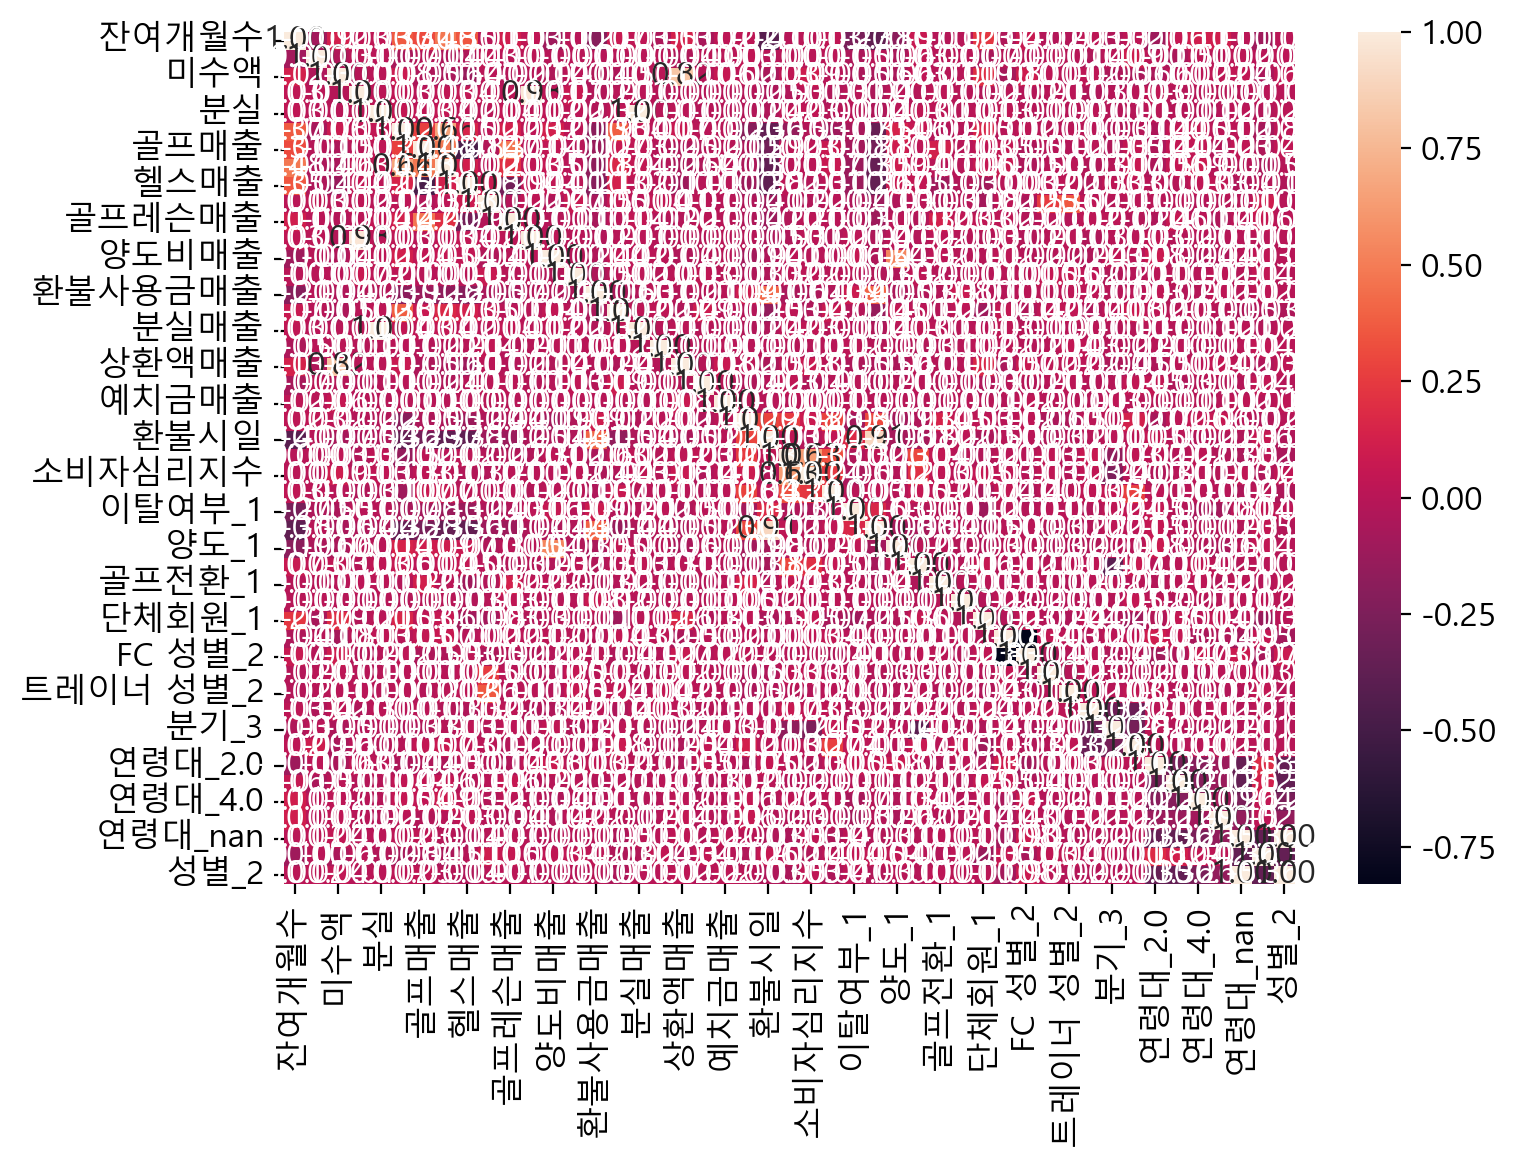

+----------------------------------------+---------------+--------------+----------+
|                                        |   correlation |      p-value | result   |
|----------------------------------------+---------------+--------------+----------|
| ('잔여개월수', '추세값')               |    -0.0927849 |  3.80553e-11 | True     |
| ('잔여개월수', '미수액')               |      0.124281 |  7.24693e-19 | True     |
| ('잔여개월수', '일일입장')             |     0.0306355 |    0.0293496 | True     |
| ('잔여개월수', '분실')                 |     0.0341211 |    0.0152333 | True     |
| ('잔여개월수', '부가서비스사용')       |      0.369567 | 1.78341e-163 | True     |
| ('잔여개월수', '골프매출')             |      0.308474 | 6.00322e-112 | True     |
| ('잔여개월수', '라카매출')             |      0.481318 |  1.0857e-291 | True     |
| ('잔여개월수', '헬스매출')             |      0.353497 | 8.86514e-149 | True     |
| ('잔여개월수', 'PT매출')               |    0.00796564 |     0.571134 | False    |
| ('잔여개월수', '골프레슨매출')         |      0.109161 |  6.97943e-

In [130]:
my_correlation(df6, method='s', heatmap=True, dpi=200, figsize=(8, 6))

In [131]:
variables=[
'이탈여부_1','잔여개월수', '미수액', '부가서비스사용', '골프매출', '라카매출', '헬스매출', 'PT매출', '골프레슨매출', '양도비매출', '환불사용금매출', '상환액매출', '거래횟수', '환불시일', '문화생활비지출', '소비자심리지수', '환불여부_1', '양도_1', '단체회원_1', '분기_4', '연령대_1.0', '연령대_2.0', '연령대_4.0', '연령대_5.0', '성별_1.0'
]
df7 =df6.filter(variables)

### 03. PCA - 주성분분석

In [132]:
df8 = df7.copy()
df7 = df7.drop("이탈여부_1",axis=1)

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [22] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [14] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [22] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[14]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


[scatterd] >INFO> Create scatterplot


+------+--------------+-------------+-------------+------------+------------+------------+----------------+--------------+------------------+--------------+------------+-------------+------------------+------------------+------------------+--------------+-------------+--------------+-------------+--------------+--------------+--------------+
|      |   잔여개월수 |      미수액 |    골프매출 |   라카매출 |   헬스매출 |     PT매출 |   골프레슨매출 |   양도비매출 |   환불사용금매출 |   상환액매출 |   거래횟수 |    환불시일 |   문화생활비지출 |   소비자심리지수 |   부가서비스사용 |   환불여부_1 |      양도_1 |   단체회원_1 |      분기_4 |   연령대_2.0 |   연령대_4.0 |   연령대_5.0 |
|------+--------------+-------------+-------------+------------+------------+------------+----------------+--------------+------------------+--------------+------------+-------------+------------------+------------------+------------------+--------------+-------------+--------------+-------------+--------------+--------------+--------------|
| PC1  |    -0.456986 |  -0.0130674 |    -0.37345 |  -0.478099 

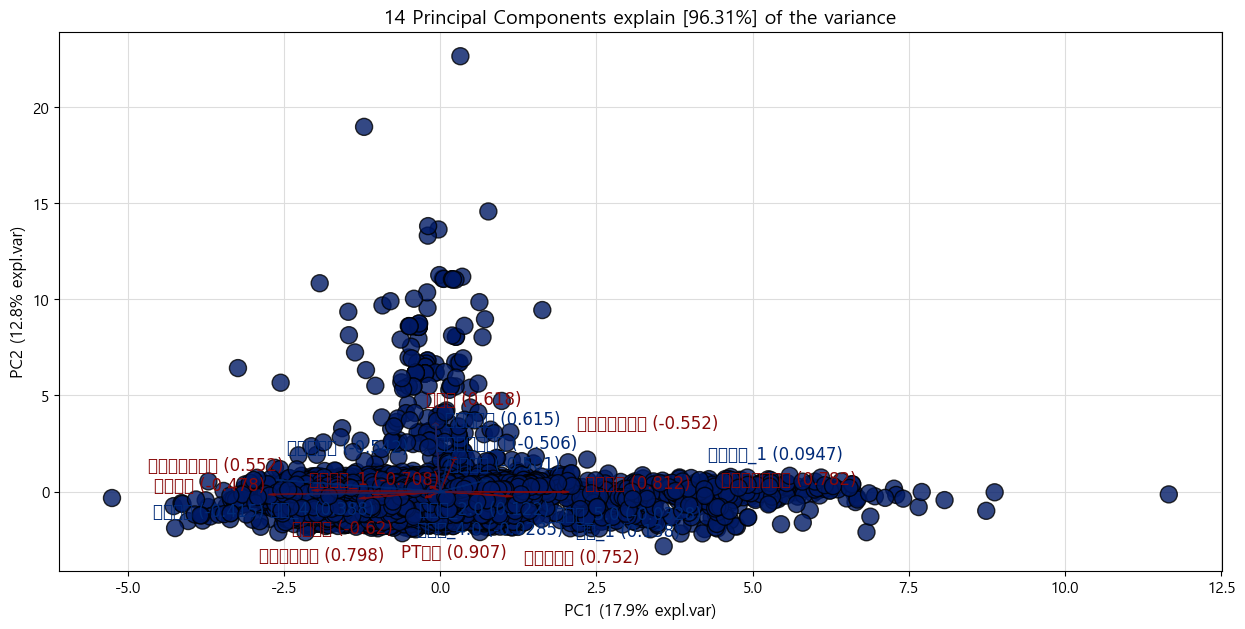

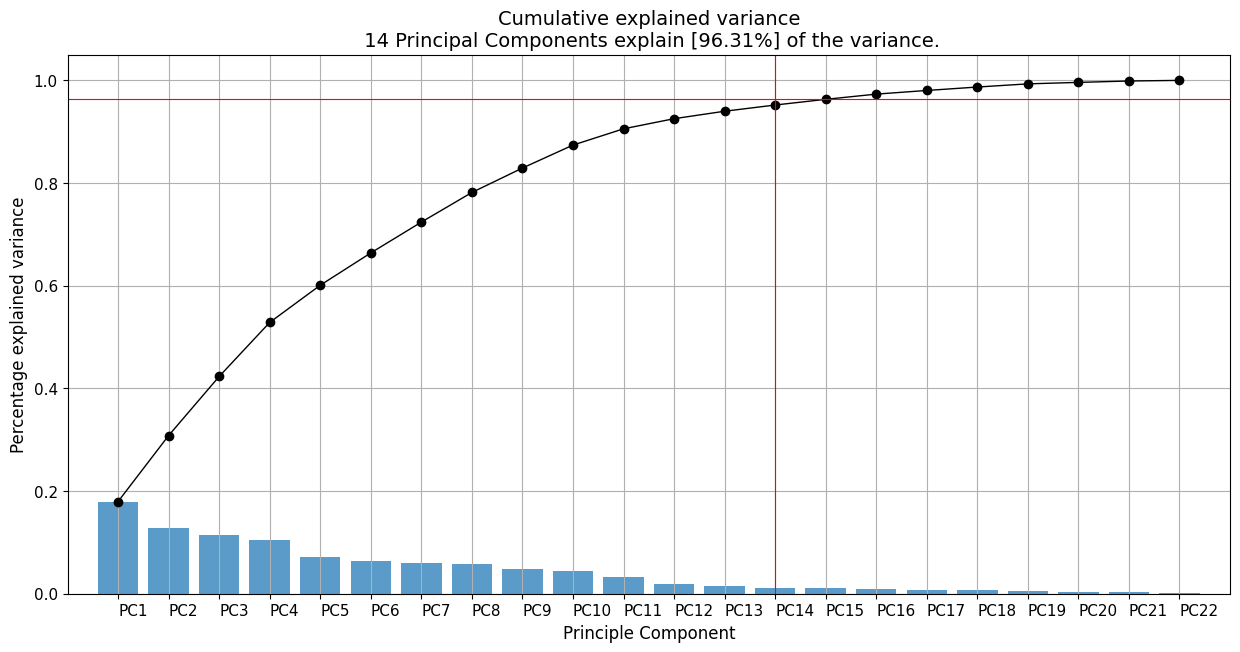

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14
0,0.115299,-1.357643,2.363028,-0.135143,-0.440071,-0.515104,-0.450391,-0.206394,0.404467,-0.034278,-1.146549,0.202208,-0.404561,0.058315
1,-1.001571,-1.354112,2.318369,-0.220669,-0.537333,-0.760956,-0.010581,-0.114102,0.064167,0.456506,-0.384228,0.287121,-0.442638,0.059701
2,0.115299,-1.357643,2.363028,-0.135143,-0.440071,-0.515104,-0.450391,-0.206394,0.404467,-0.034278,-1.146549,0.202208,-0.404561,0.058315
3,-1.708077,-1.321205,1.316237,1.809295,-0.397912,-0.510368,0.060013,-0.187292,-1.119743,-0.184341,-0.806243,0.315378,-0.502619,-0.037704
4,0.227637,-1.401333,2.388873,-0.183324,-0.361231,-0.470009,-0.487407,-0.212360,0.415673,-0.073226,-0.976455,0.289783,-0.389309,0.138260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5053,0.736291,-0.450618,0.433351,0.180116,0.070464,1.746793,-0.197540,0.103748,-0.479324,-0.351707,0.679934,0.423098,0.453480,-0.351426
5054,0.110380,-0.375254,0.745812,-1.286637,-0.202088,-0.387752,-0.572316,0.211512,0.498996,0.089218,-1.110613,0.638776,0.210069,-0.125021
5055,-0.752190,-0.520446,-0.659562,1.872447,0.546204,0.287471,-0.830919,0.095287,0.016625,-0.481856,-0.438979,0.386170,0.966784,0.296188
5056,0.749055,-0.457593,0.439707,0.180244,0.098941,1.763556,-0.211625,0.110205,-0.477993,-0.365118,0.679513,0.439660,0.461687,-0.370916


In [133]:
my_pca(df7)

## 04. 머신러닝

### 01. 모델 비교

In [138]:
x_train, x_test, y_train, y_test = my_train_test_split(df9, "이탈여부_1", scalling=True)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((4046, 19), (1012, 19), (4046,), (1012,))

[LightGBM] [Info] Number of positive: 2839, number of negative: 1207
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000239 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 4046, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.701681 -> initscore=0.855314
[LightGBM] [Info] Start training from score 0.855314


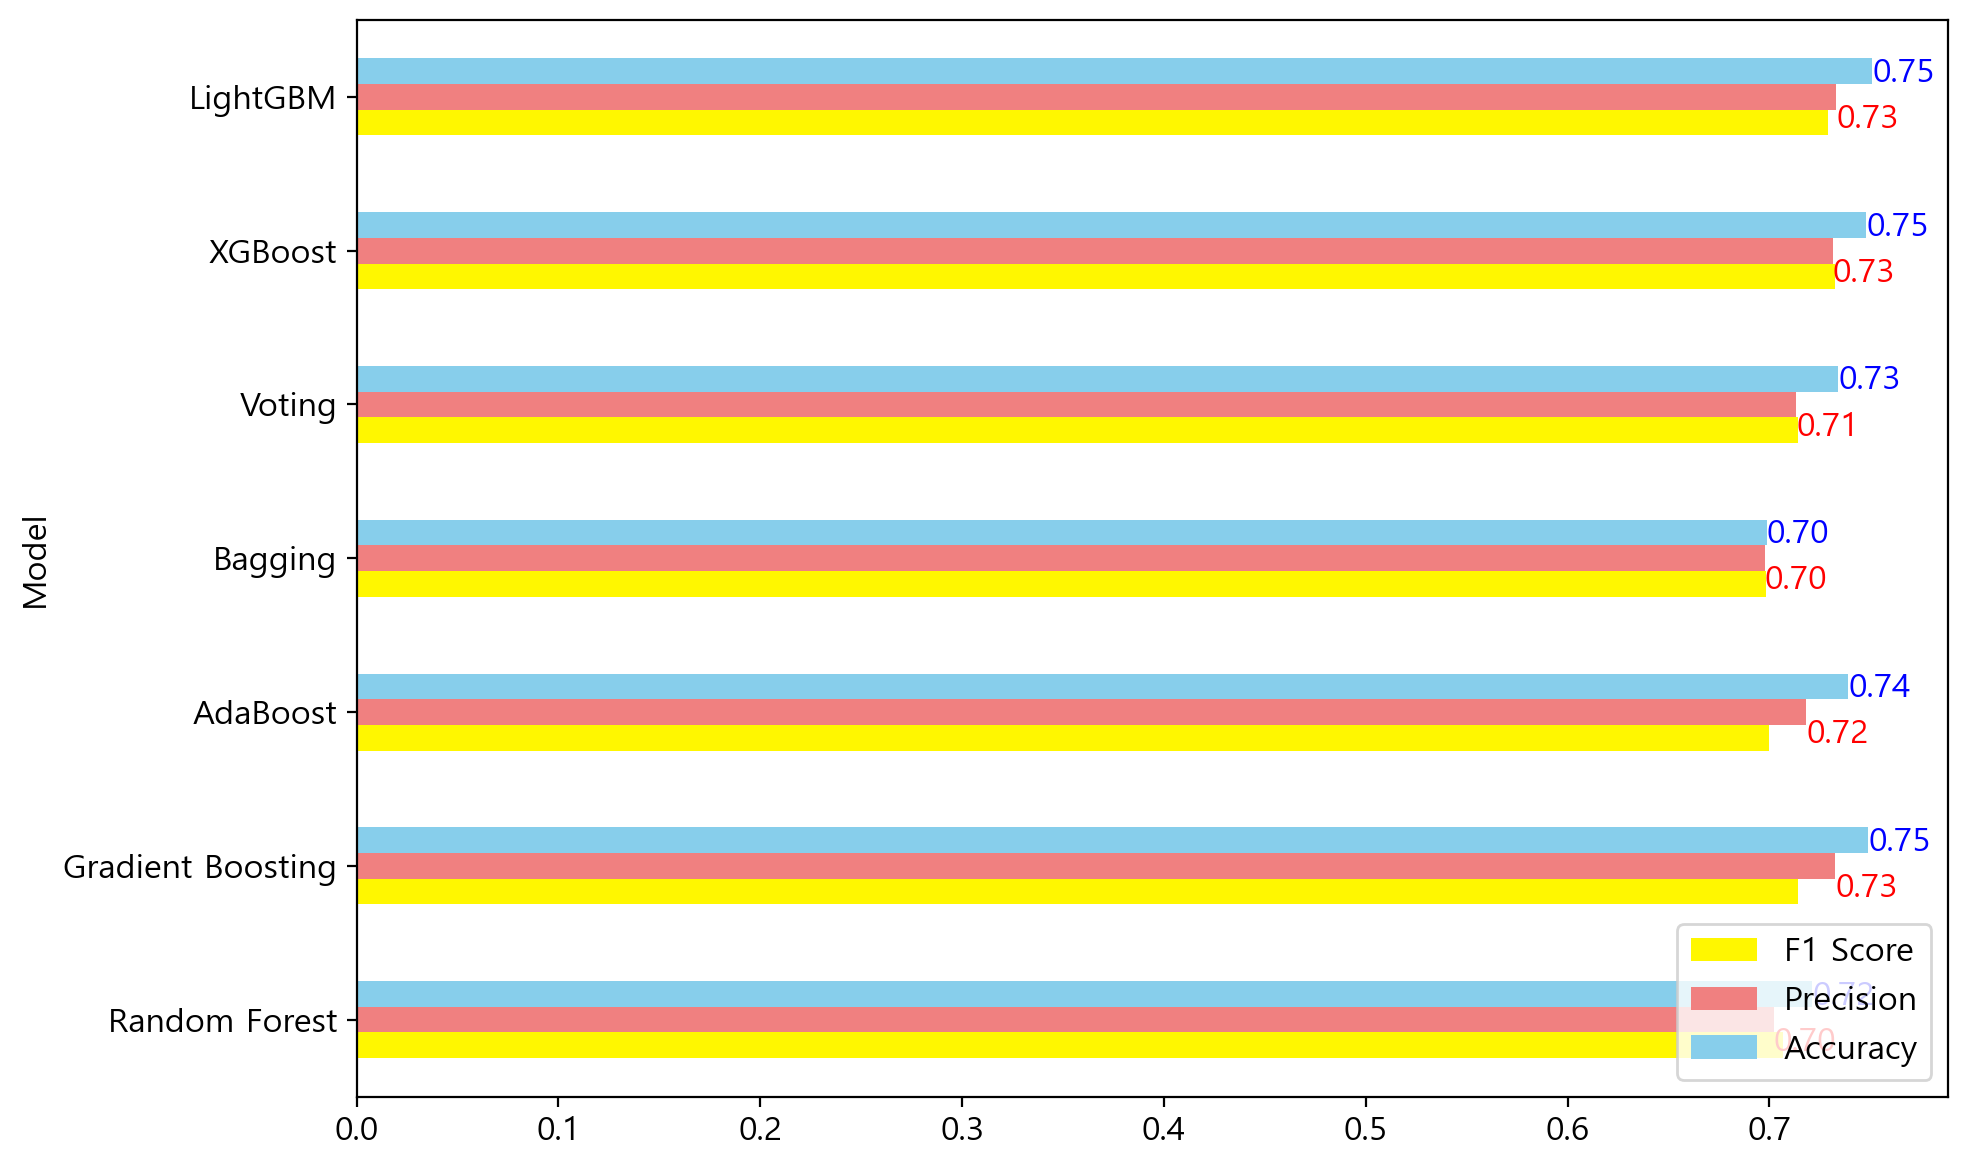

In [139]:
# 모델 리스트
models = {
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Bagging": BaggingClassifier(),
    "Voting": VotingClassifier(estimators=[
        ('lr', LogisticRegression()),
        ('dt', DecisionTreeClassifier()),
        ('rf', RandomForestClassifier())
    ], voting='hard'),
    "XGBoost": XGBClassifier(),
    "LightGBM": LGBMClassifier()
}

# 성능 평가 결과 저장용 리스트
results_list = []

# 각 모델별 학습 및 평가
for model_name, model in models.items():
    # 모델 학습
    model.fit(x_train, y_train)
    
    # 예측
    y_pred = model.predict(x_test)
    
    # 성능 평가
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # 결과 저장
    results_list.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

# 결과를 데이터프레임으로 변환
results = pd.DataFrame(results_list)

# 결과를 시각화
fig, ax = plt.subplots(figsize=(10, 6))

# 모델명을 y축으로 설정
results.set_index('Model', inplace=True)

# 정밀도와 정확도를 다른 색상으로 시각화
results[['F1 Score','Precision', 'Accuracy']].plot(kind='barh', ax=ax, color=['#FFF700','lightcoral', 'skyblue'])


# 각 막대 위에 성능 지표 값을 표시
for index, value in enumerate(results['Precision']):
    ax.text(value, index - 0.15, f'{value:.2f}', color='red', va='center')

for index, value in enumerate(results['Accuracy']):
    ax.text(value, index + 0.15, f'{value:.2f}', color='blue', va='center')

# 범례 설정
ax.legend(['F1 Score','Precision', 'Accuracy'], loc='lower right')

plt.tight_layout()
plt.show()

### 02. LightGBM

In [140]:
estimator = LGBMClassifier(
    num_leaves=64,
    n_jobs=get_n_jobs(),
    random_state=get_random_state(),
    early_stopping_rounds=5,
    verbose=-1,
)


params = {
    "learning_rate": [0.1, 0.3, 0.5, 0.7, 1],
    "n_estimators": [100, 200, 300, 400, 500],
    "min_child_weight": [1, 3, 5, 7, 9],
    "max_depth": [0, 2, 4, 6],
    "subsample": [0.5, 0.7, 1],
    "colsample_bytree": [0.6, 0.7, 0.8, 0.9],
    "lambda_l1": [0, 1, 3, 5, 7],
    "lambda_l2": [0, 1, 3, 5, 7],
}

estimator = RandomizedSearchCV(
    estimator,
    param_distributions=params,
    n_jobs=get_n_jobs(),
    cv=5,
    random_state=get_random_state(),
)

estimator.fit(
    x_train,
    y_train,
    eval_metric="error",
    eval_set=[(x_train, y_train), (x_test, y_test)],
)

RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(early_stopping_rounds=5, n_jobs=-1,
                                            num_leaves=64, random_state=0,
                                            verbose=-1),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8,
                                                             0.9],
                                        'lambda_l1': [0, 1, 3, 5, 7],
                                        'lambda_l2': [0, 1, 3, 5, 7],
                                        'learning_rate': [0.1, 0.3, 0.5, 0.7,
                                                          1],
                                        'max_depth': [0, 2, 4, 6],
                                        'min_child_weight': [1, 3, 5, 7, 9],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500],
                                        'subsample': [0.5, 0.7, 1]},
                   random_state=0)

In [141]:
result_df = DataFrame(estimator.cv_results_["params"])
result_df["mean_test_score"] = estimator.cv_results_["mean_test_score"]
result_df.dropna(subset=["mean_test_score"], inplace=True)
result_df.sort_values(by="mean_test_score", ascending=False, inplace=True)
result_df.reset_index(drop=True, inplace=True)

my_pretty_table(result_df.head(10))

+----+-------------+----------------+--------------------+-------------+-----------------+-------------+-------------+--------------------+-------------------+
|    |   subsample |   n_estimators |   min_child_weight |   max_depth |   learning_rate |   lambda_l2 |   lambda_l1 |   colsample_bytree |   mean_test_score |
|----+-------------+----------------+--------------------+-------------+-----------------+-------------+-------------+--------------------+-------------------|
|  0 |         0.7 |            500 |                  5 |           4 |             0.5 |           3 |           1 |                0.8 |          0.747159 |
|  1 |           1 |            500 |                  3 |           4 |             0.7 |           1 |           1 |                0.9 |          0.745924 |
|  2 |         0.5 |            100 |                  1 |           0 |             0.5 |           3 |           1 |                0.7 |          0.743944 |
|  3 |           1 |            300 |   

[분류분석 성능평가]
+-------------------+--------------+--------------+-----------------------------------------------------------+
|                   |   훈련데이터 |   검증데이터 | 설명                                                      |
|-------------------+--------------+--------------+-----------------------------------------------------------|
| 정확도(Accuracy)  |     0.756303 |     0.748024 | 예측 결과(TN,FP,TP,TN)가 실제 결과(TP,TN)와 일치하는 정도 |
| 정밀도(Precision) |      0.76018 |     0.765589 | 양성으로 예측한 결과(TP,FP) 중 실제 양성(TP)인 비율       |
| 재현율(Recall)    |     0.953505 |     0.927273 | 실제 양성(TP,FN) 중 양성(TP)으로 예측한 비율              |
| 위양성율(Fallout) |     0.707539 |     0.683502 | 실제 음성(FP,TN) 중 양성(FP)으로 잘못 예측한 비율         |
| 특이성(TNR)       |     0.292461 |     0.316498 | 실제 음성(FP,TN) 중 음성(TN)으로 정확히 예측한 비율       |
| F1 Score          |     0.845938 |      0.83871 | 정밀도와 재현율의 조화평균                                |
| AUC               |     0.767944 |     0.725749 | ROC Curve의 면적으로, 1에 가까울수록 좋은 모델            |
+--

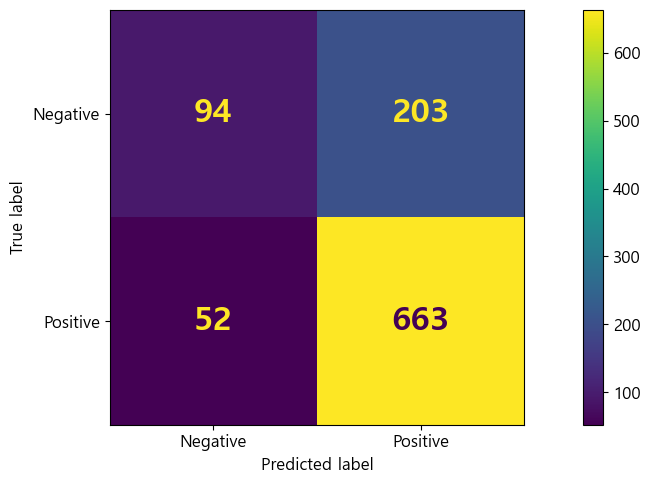


[변수 중요도]


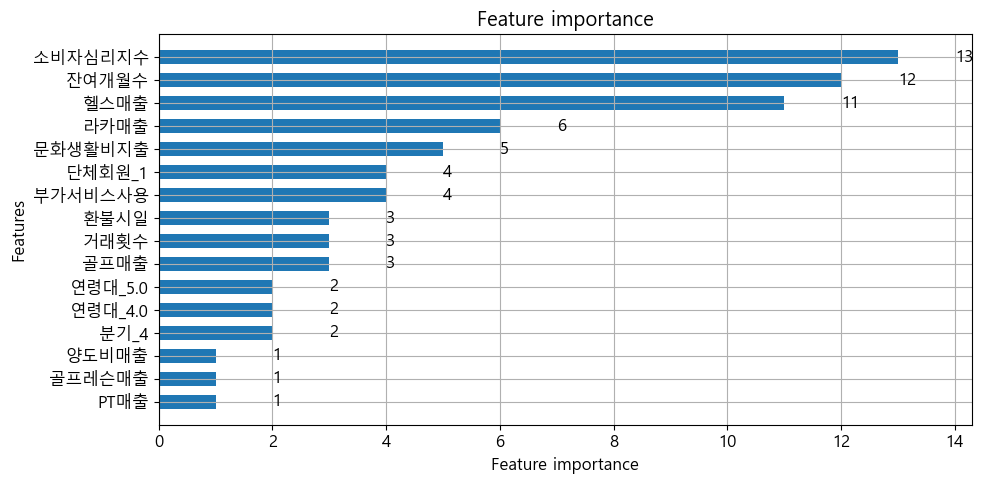

+----------------+---------+-----------+----------+
|                |   score |      rate |   cumsum |
|----------------+---------+-----------+----------|
| 소비자심리지수 |      13 |  0.178082 | 0.178082 |
| 잔여개월수     |      12 |  0.164384 | 0.342466 |
| 헬스매출       |      11 |  0.150685 | 0.493151 |
| 라카매출       |       6 | 0.0821918 | 0.575342 |
| 문화생활비지출 |       5 | 0.0684932 | 0.643836 |
| 부가서비스사용 |       4 | 0.0547945 |  0.69863 |
| 단체회원_1     |       4 | 0.0547945 | 0.753425 |
| 골프매출       |       3 | 0.0410959 | 0.794521 |
| 거래횟수       |       3 | 0.0410959 | 0.835616 |
| 환불시일       |       3 | 0.0410959 | 0.876712 |
| 연령대_4.0     |       2 | 0.0273973 |  0.90411 |
| 분기_4         |       2 | 0.0273973 | 0.931507 |
| 연령대_5.0     |       2 | 0.0273973 | 0.958904 |
| 양도비매출     |       1 | 0.0136986 | 0.972603 |
| 골프레슨매출   |       1 | 0.0136986 | 0.986301 |
| PT매출         |       1 | 0.0136986 |        1 |
| 미수액         |       0 |         0 |        1 |
| 연령대_2.0     |       0 |         

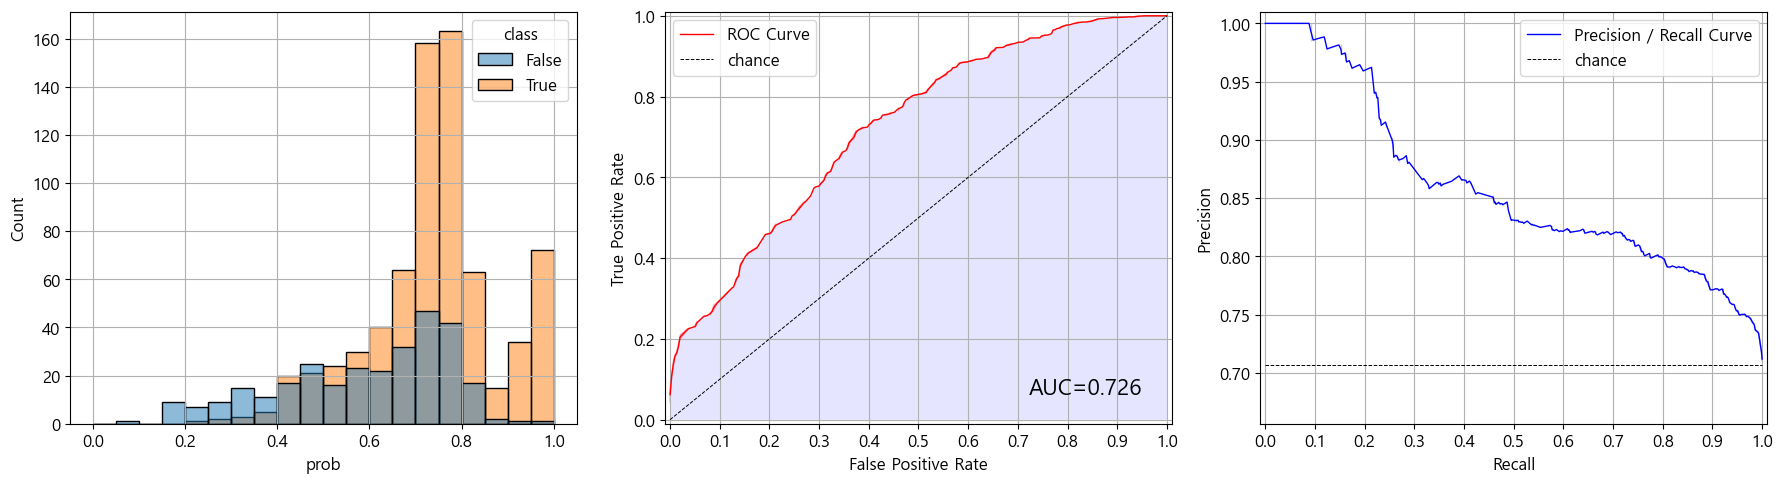


[학습곡선]


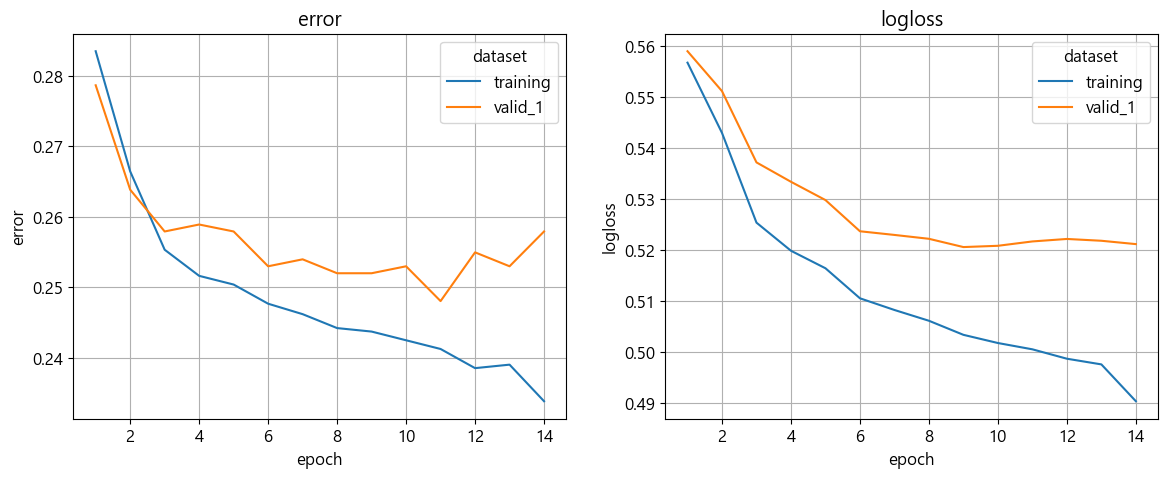

In [142]:
my_classification_result(estimator.best_estimator_, x_train, y_train, x_test, y_test)

In [143]:
my_classification_report(estimator.best_estimator_, x_train, y_train, x_test, y_test)

+----+------------+----------------+---------+
|    | 종속변수   | 독립변수       |     VIF |
|----+------------+----------------+---------|
|  0 | 이탈여부_1 | 잔여개월수     | 3.98628 |
|  1 | 이탈여부_1 | 미수액         | 1.44741 |
|  2 | 이탈여부_1 | 부가서비스사용 | 1.92844 |
|  3 | 이탈여부_1 | 골프매출       | 4.04367 |
|  4 | 이탈여부_1 | 라카매출       | 2.36305 |
|  5 | 이탈여부_1 | 헬스매출       | 4.24392 |
|  6 | 이탈여부_1 | PT매출         | 1.02558 |
|  7 | 이탈여부_1 | 골프레슨매출   |  1.1987 |
|  8 | 이탈여부_1 | 양도비매출     | 1.06494 |
|  9 | 이탈여부_1 | 환불사용금매출 | 1.14978 |
| 10 | 이탈여부_1 | 거래횟수       |  1.3532 |
| 11 | 이탈여부_1 | 환불시일       | 1.57312 |
| 12 | 이탈여부_1 | 문화생활비지출 | 2.48561 |
| 13 | 이탈여부_1 | 소비자심리지수 | 2.25801 |
| 14 | 이탈여부_1 | 단체회원_1     | 1.21458 |
| 15 | 이탈여부_1 | 분기_4         | 1.06823 |
| 16 | 이탈여부_1 | 연령대_2.0     | 1.08816 |
| 17 | 이탈여부_1 | 연령대_4.0     | 1.08866 |
| 18 | 이탈여부_1 | 연령대_5.0     | 1.06126 |
+----+------------+----------------+---------+


### 03. Shap

[LightGBM] [Info] Number of positive: 2839, number of negative: 1207
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000210 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 4046, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.701681 -> initscore=0.855314
[LightGBM] [Info] Start training from score 0.855314


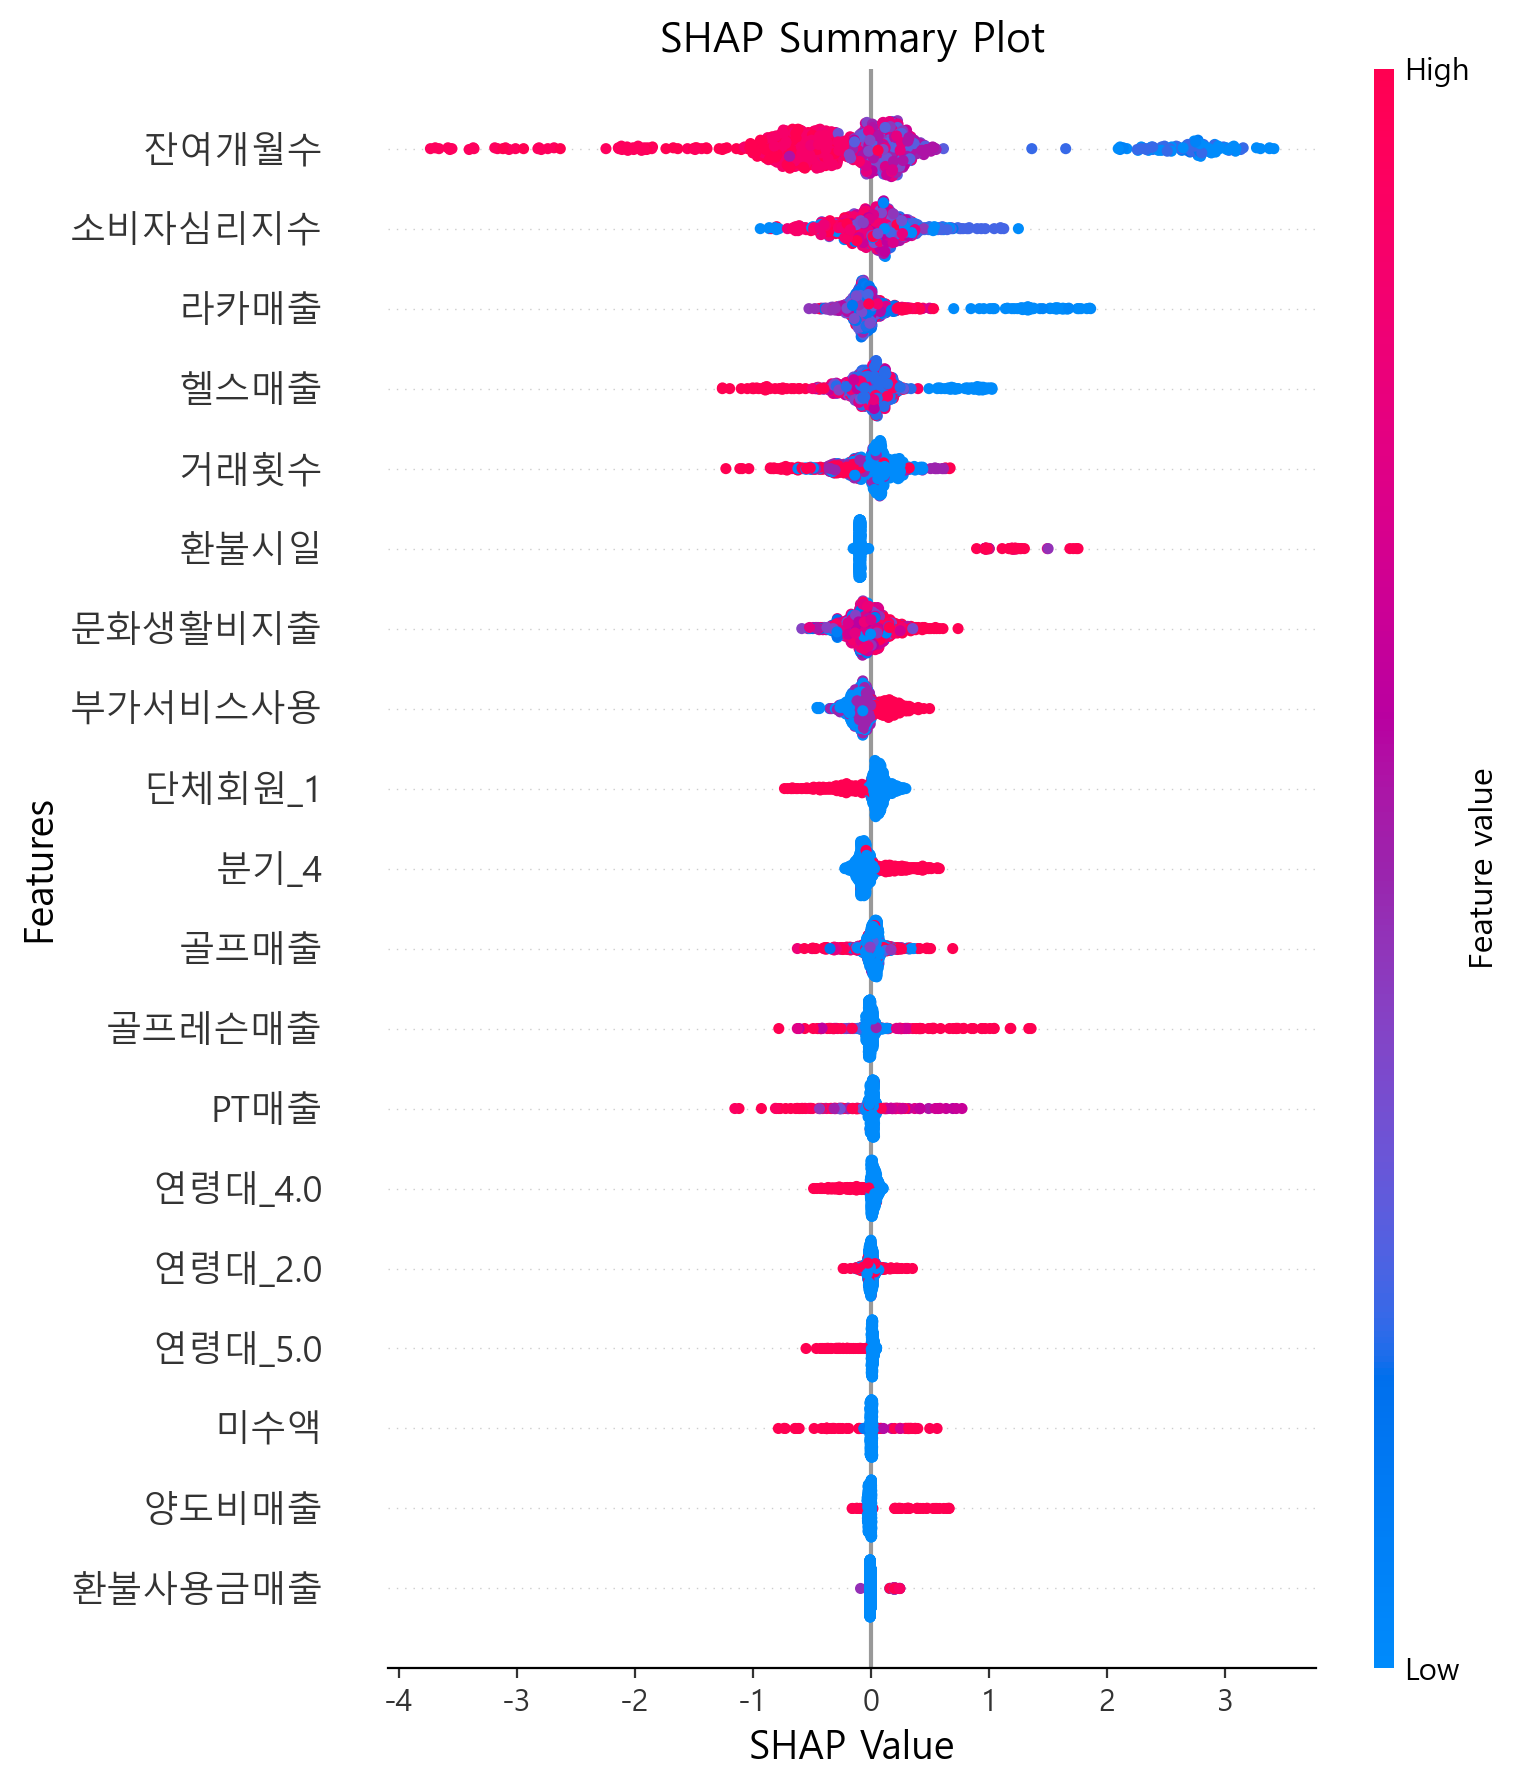

In [144]:
# 모델 학습
model = LGBMClassifier()
                               
model.fit(x_train, y_train)

# SHAP 값을 계산
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_test)

# Dot Plot 생성
plt.rcParams['axes.unicode_minus'] = False
fig = plt.figure(figsize=(10, 8))  # 크기를 키워서 가독성 향상
fig.set_facecolor('white')
ax = fig.add_subplot()

shap.summary_plot(
    shap_values,
    x_test,
    feature_names=x_test.columns,
    plot_type='dot',  # dot plot을 명시적으로 설정
    color_bar=True,
    show=False
)

# 그래프 제목 및 축 레이블 추가
ax.set_xlabel('SHAP Value', fontsize=14)
ax.set_ylabel('Features', fontsize=14)
ax.set_title('SHAP Summary Plot', fontsize=15)
plt.tight_layout()
plt.show()

### 04. Segmentation

In [145]:
df8.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5058 entries, 0 to 5057
Data columns (total 23 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   이탈여부_1   5058 non-null   bool    
 1   잔여개월수    5058 non-null   int64   
 2   미수액      5058 non-null   int64   
 3   부가서비스사용  5058 non-null   category
 4   골프매출     5058 non-null   int64   
 5   라카매출     5058 non-null   int64   
 6   헬스매출     5058 non-null   int64   
 7   PT매출     5058 non-null   int64   
 8   골프레슨매출   5058 non-null   int64   
 9   양도비매출    5058 non-null   int64   
 10  환불사용금매출  5058 non-null   int64   
 11  상환액매출    5058 non-null   int64   
 12  거래횟수     5058 non-null   int64   
 13  환불시일     5058 non-null   int64   
 14  문화생활비지출  5058 non-null   int64   
 15  소비자심리지수  5058 non-null   int32   
 16  환불여부_1   5058 non-null   bool    
 17  양도_1     5058 non-null   bool    
 18  단체회원_1   5058 non-null   bool    
 19  분기_4     5058 non-null   bool    
 20  연령대_2.0  5058 non-null   bool 

In [146]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# 데이터 표준화
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df8)

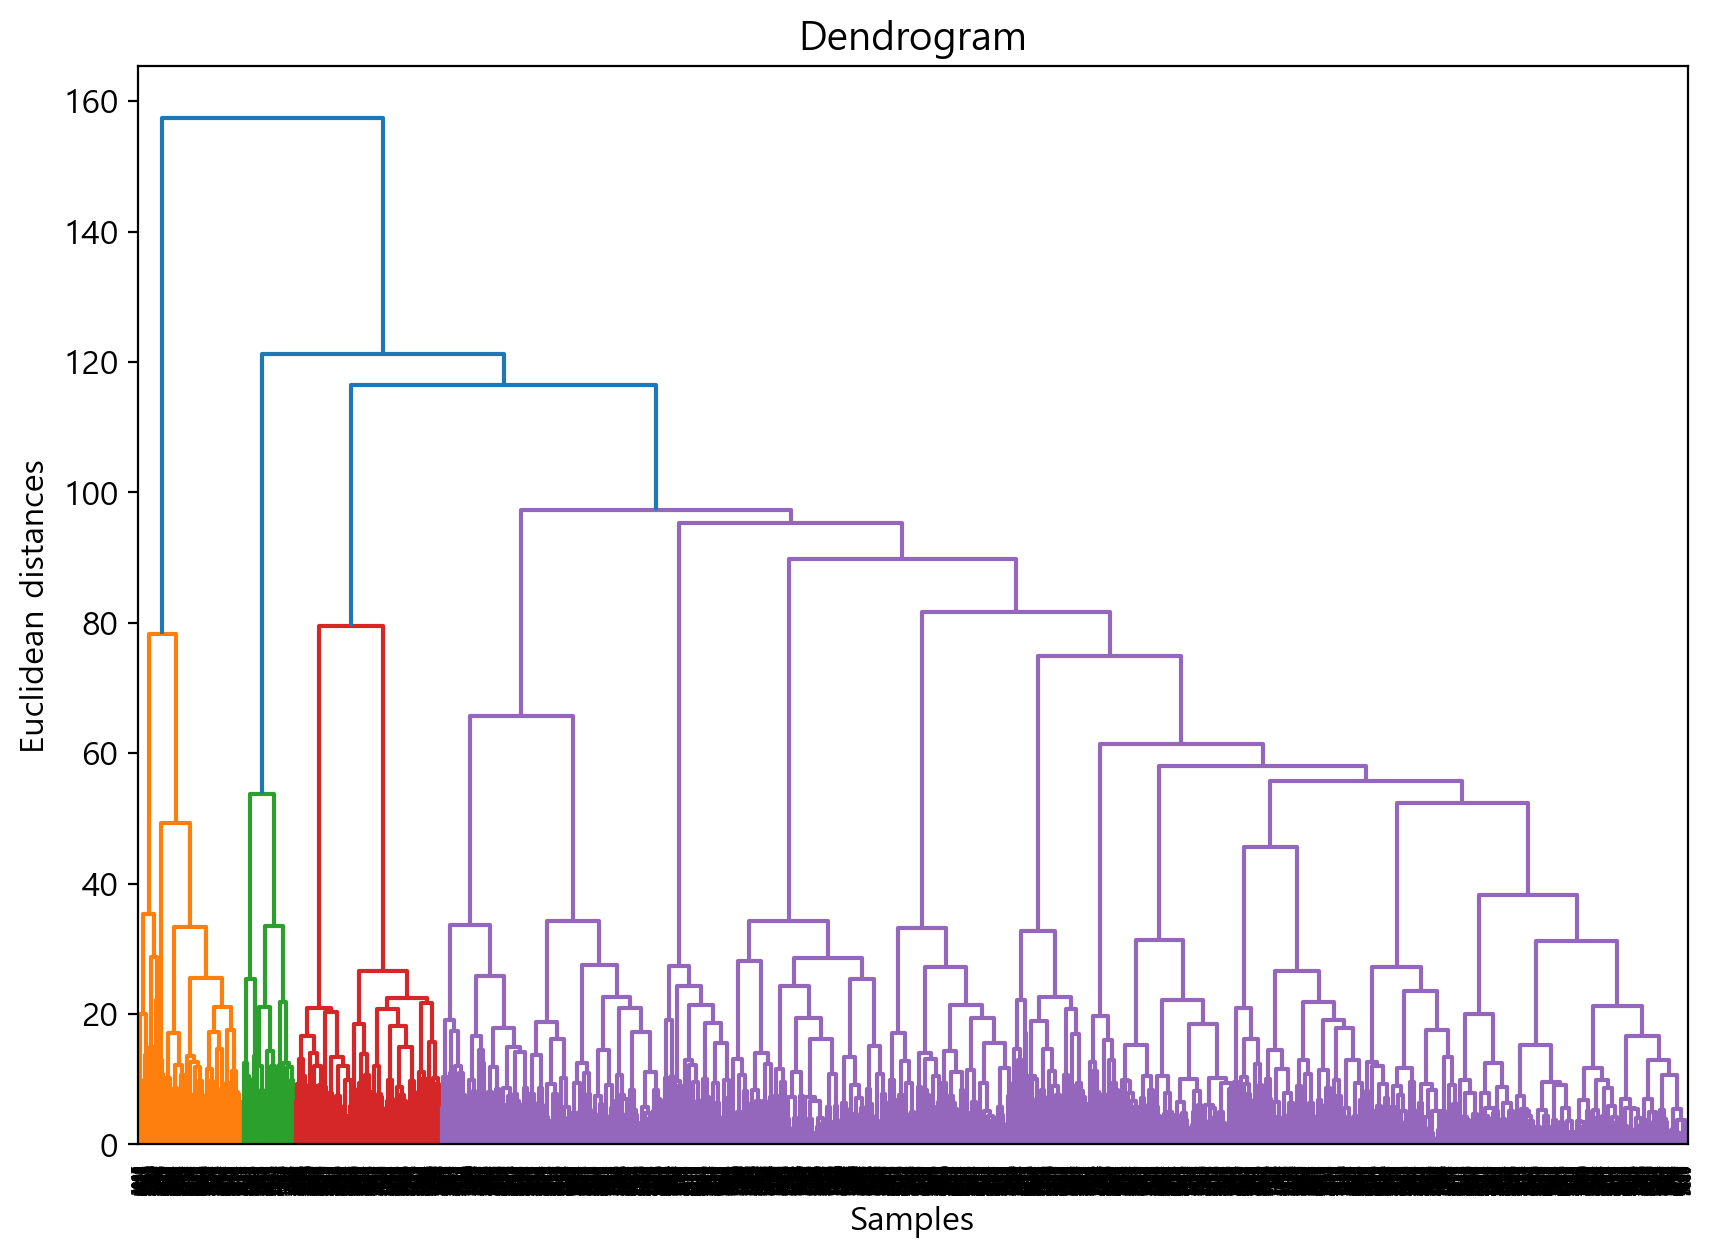

In [147]:
# 계층적 군집화 수행 (Ward's method 사용)
linked = linkage(scaled_data, method='ward')

# 덴드로그램 시각화
plt.figure(figsize=(10, 7))
dendrogram(linked, labels=df8.index.tolist())
plt.title('Dendrogram')
plt.xlabel('Samples')
plt.ylabel('Euclidean distances')
plt.show()

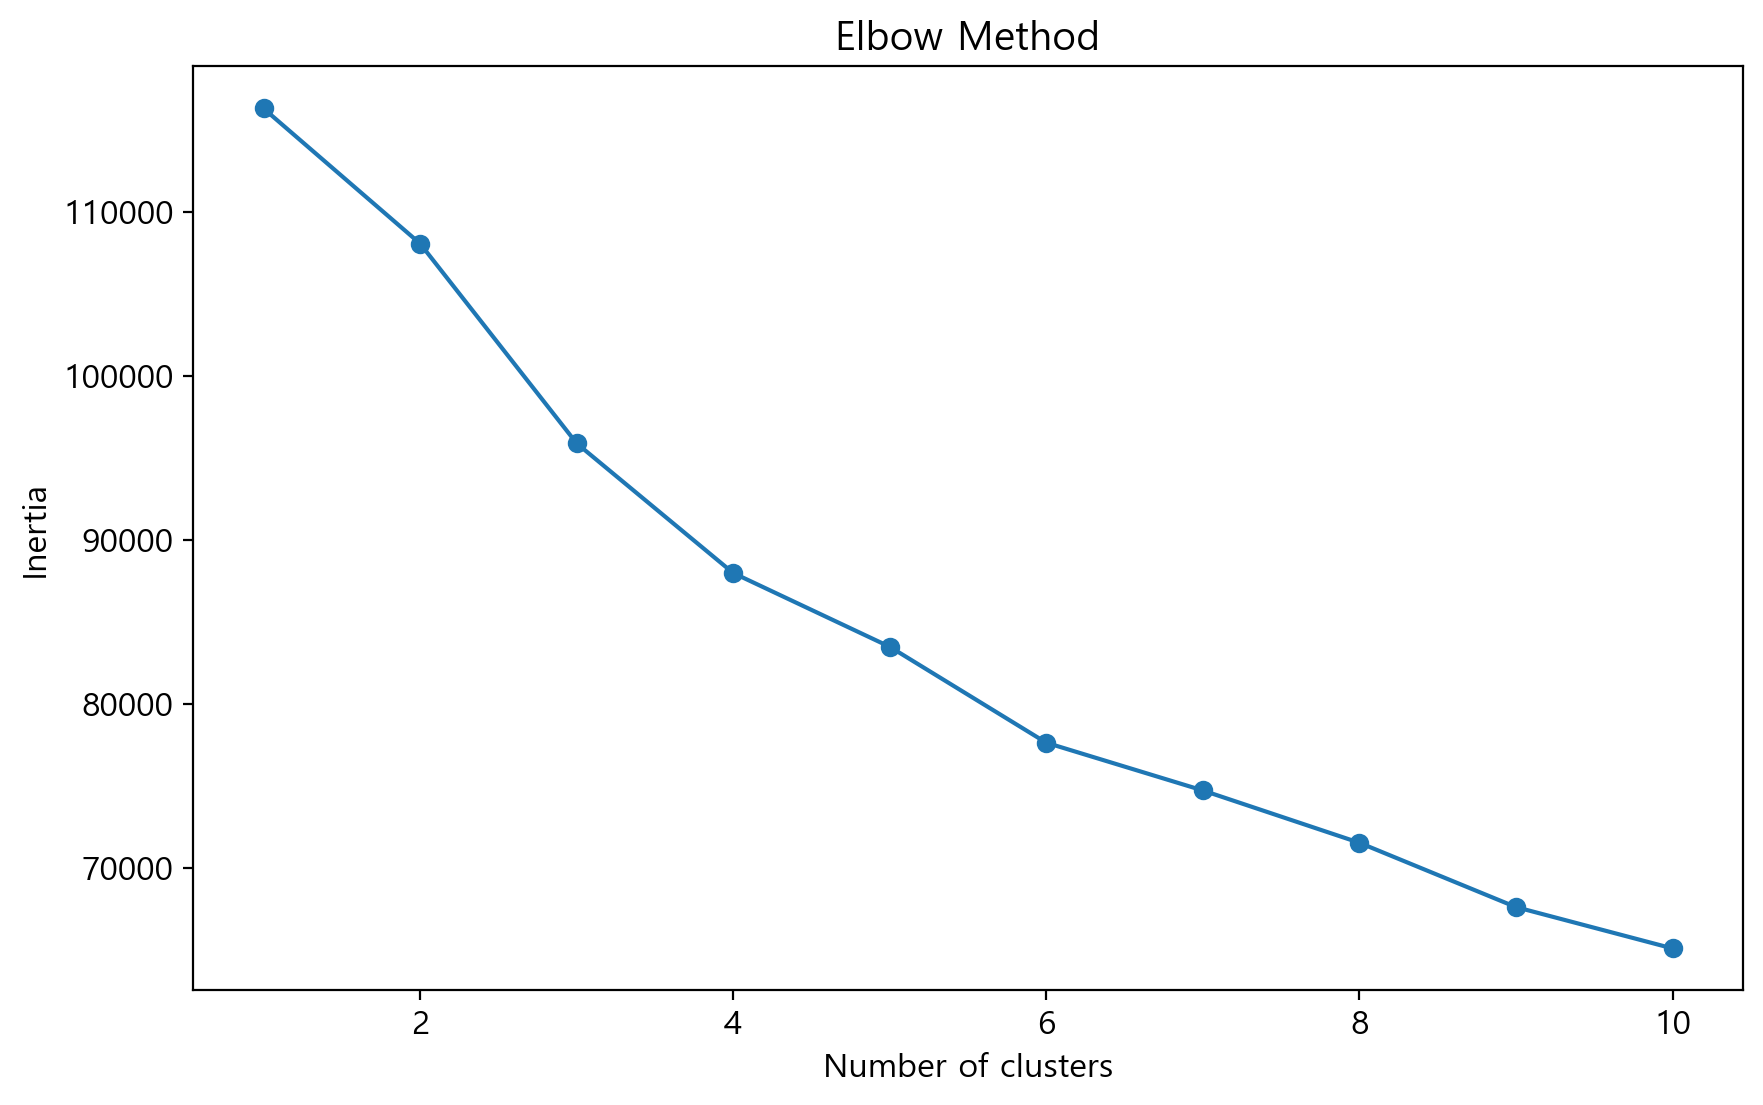

In [155]:
from sklearn.cluster import KMeans

# 엘보우 방법을 사용하여 최적의 클러스터 수 찾기
inertia = []
for n in range(1, 11):
    kmeans = KMeans(n_clusters=n, random_state=0)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

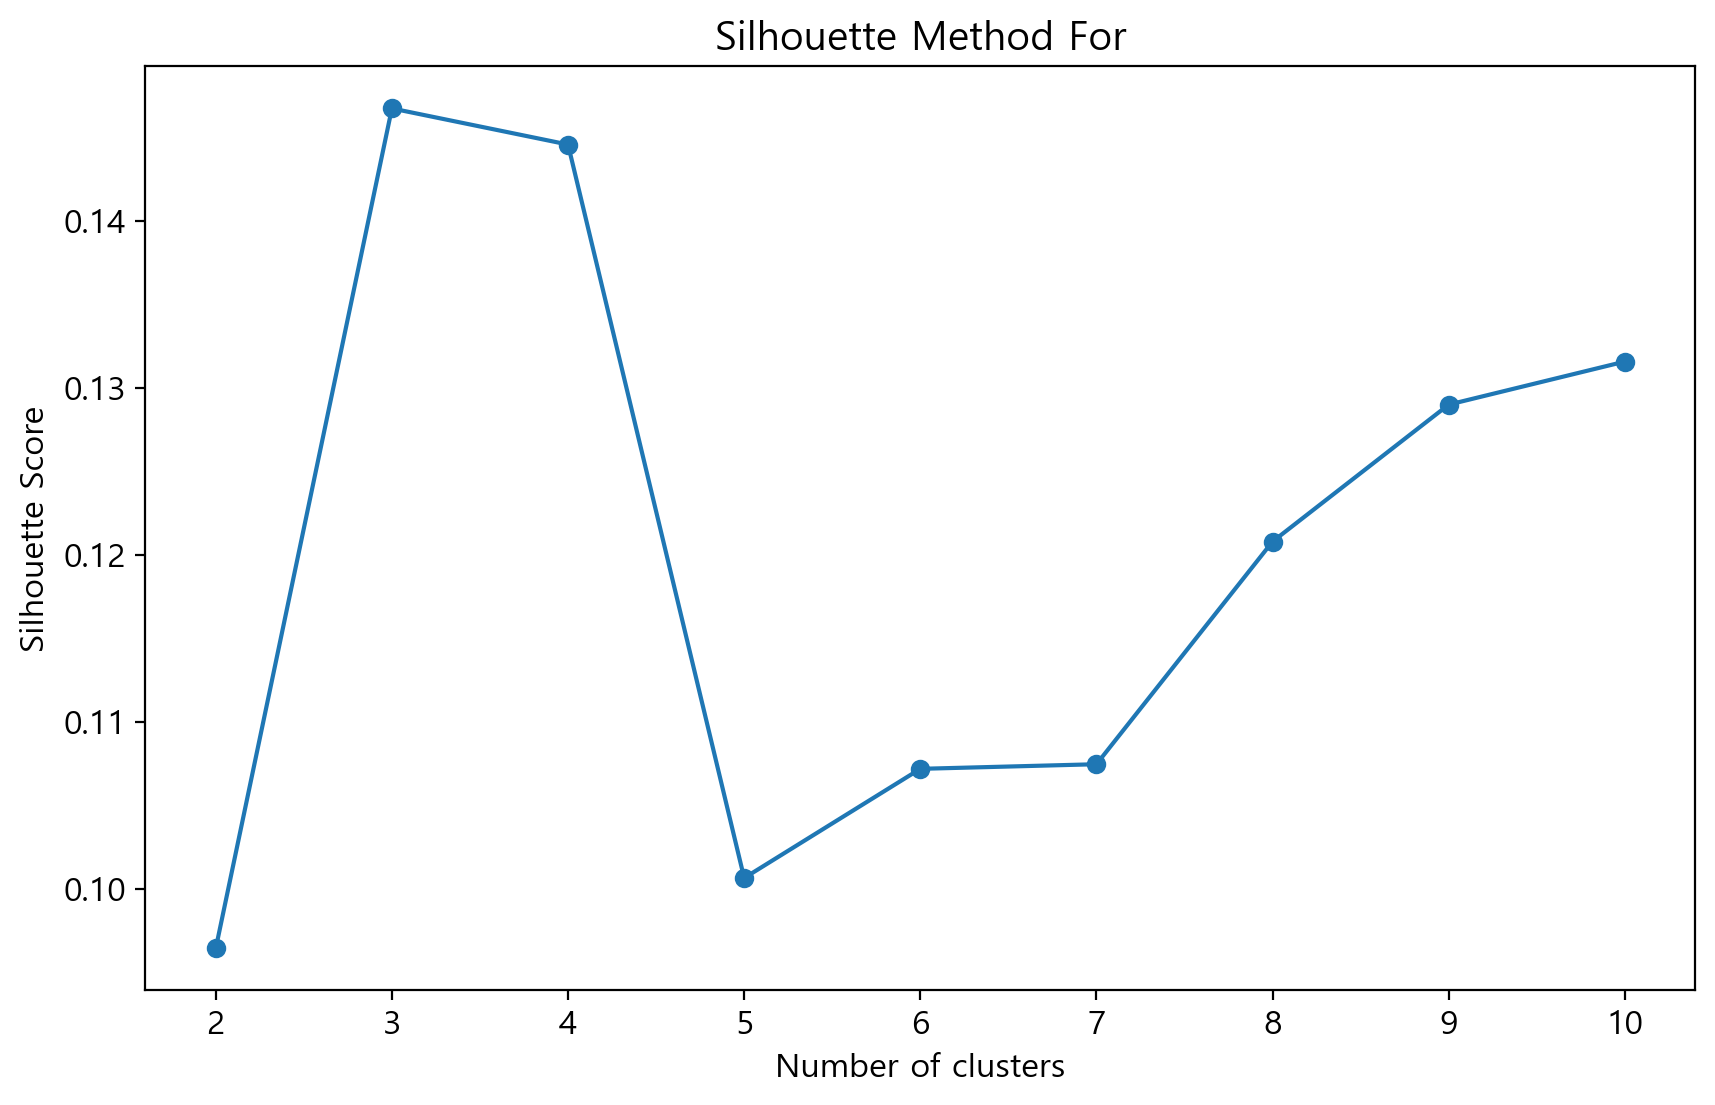

In [157]:
from sklearn.metrics import silhouette_score

# 실루엣 계수를 사용하여 최적의 클러스터 수 찾기
silhouette_scores = []
for n in range(2, 11):
    kmeans = KMeans(n_clusters=n, random_state=0)
    kmeans.fit(scaled_data)
    score = silhouette_score(scaled_data, kmeans.labels_)
    silhouette_scores.append(score)

plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method For')
plt.show()

In [152]:
from scipy.cluster.hierarchy import fcluster

# 최적의 클러스터 수 설정
optimal_clusters = 3  # 예시 클러스터 수, 엘보우와 실루엣 결과를 기반으로 설정

# 계층적 군집화 수행
clusters = fcluster(linked, optimal_clusters, criterion='maxclust')

# 원본 데이터프레임에 클러스터 라벨 추가
df8['Cluster'] = clusters
print(df8)

      이탈여부_1  잔여개월수  미수액 부가서비스사용     골프매출    라카매출     헬스매출     PT매출  골프레슨매출  \
0       True     12    0       0        0       0   899000        0       0   
1       True     14    0       1        0  100000  1080000        0       0   
2      False     12    0       0        0       0   899000        0       0   
3      False     14    0       1  1320000  180000        0        0       0   
4      False     10    0       0        0       0   990000        0       0   
...      ...    ...  ...     ...      ...     ...      ...      ...     ...   
5053    True      0    0       1        0   45000        0  1650000       0   
5054   False     12    0       0        0       0  1188000        0       0   
5055    True      4    0       1  1788000   60000        0        0  360000   
5056    True      0    0       1        0   45000        0  1650000       0   
5057    True      5    0       0        0       0  1308000        0       0   

      양도비매출  ...  문화생활비지출  소비자심리지수  환불여부_1   양도_1  

In [160]:
# 범주형 변수 제거
numeric_columns = df8.select_dtypes(include=['number']).columns

# 수치형 변수들에 대해 클러스터별 통계량 계산
cluster_summary = df8[numeric_columns].groupby('Cluster').agg(['mean', 'std', 'min', 'max'])

# 중간에 생략되는 값이 없도록 출력 옵션 설정
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# 클러스터별 통계량 출력
print(cluster_summary)

# 출력 옵션 원래대로 되돌리기
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

             잔여개월수                             미수액                         \
              mean       std min max          mean            std     min   
Cluster                                                                     
1        -2.257225  4.825087 -12  15  2.690751e+03   52941.748420 -300000   
2        11.882353  3.002609   0  27  1.080494e+06  556368.485844       0   
3         8.496257  5.658322 -24  24  4.801931e+03   52320.026925 -555000   

                           골프매출                                   \
             max           mean            std      min      max   
Cluster                                                            
1         720000 -497846.820809  748155.565629 -2028000  1580000   
2        3850000   35011.764706  195087.356802 -1360000  1070000   
3        1380000  379621.567371  660631.370184 -1896000  2700000   

                 라카매출                                         헬스매출  \
                 mean           std     min     max       